In [51]:
!pip install --upgrade tensorflow-gpu==2.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [52]:
!pip install nltk
!pip install gensim
!pip install spacy
!pip install plotly

In [53]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
!pip install jupyterthemes

In [55]:
from collections import Counter
import operator
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [56]:
# load the data
df_english = pd.read_csv('small_vocab_en.csv', sep = '/t', names = ['english'])
df_french = pd.read_csv('small_vocab_fr.csv', sep = '/t', names = ['french'])

<ipython-input-56-fb6af57a13c8>:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.

<ipython-input-56-fb6af57a13c8>:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [57]:
# Concatenate english and french
df = pd.concat([df_english, df_french], axis = 1)
df

,english,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."
...,...,...
137855,"france is never busy during march , and it is ...","la france est jamais occupée en mars , et il e..."
137856,"india is sometimes beautiful during spring , a...","l' inde est parfois belle au printemps , et il..."
137857,"india is never wet during summer , but it is s...","l' inde est jamais mouillé pendant l' été , ma..."
137858,"france is never chilly during january , but it...","la france est jamais froid en janvier , mais i..."


In [58]:
print("Total English Records = {}".format(len(df['english'])))
print("Total French Records = {}".format(len(df['french'])))

Total English Records = 137860
Total French Records = 137860


In [59]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
#remove punctuations
def remove_punc(x):
  return re.sub('[!#?,.:";]', '', x)

In [61]:
df['french'] = df['french'].apply(remove_punc)
df['english'] = df['english'].apply(remove_punc)

In [62]:
english_words = []
french_words  = []

In [63]:
# list of unique words
def get_label_superset(x, word_list):
    for label in x.split():
        if label not in word_list:
            word_list.append(label)

df['english'].apply(lambda x: get_label_superset(x, english_words))
df['french'].apply(lambda x: get_label_superset(x, french_words))

# number of unique words in english
total_english_words  = len(english_words)
total_english_words



199

In [64]:
# number of unique words in french
total_french_words = len(french_words)
total_french_words

350

#  VISUALIZE CLEANED UP DATASET

In [65]:
# list of all words in the dataset
words = []
for i in df['english']:
  for word in i.split():
    words.append(word)


In [66]:
#  total count of words
english_words_counts = Counter(words)

In [67]:
# sort the dictionary by values
english_words_counts = sorted(english_words_counts.items(), key = operator.itemgetter(1), reverse = True)

In [68]:
# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(english_words_counts)):
  english_words.append(english_words_counts[i][0])
  english_counts.append(english_words_counts[i][1])

In [69]:
# Plot barplot using plotly
fig = px.bar(x = english_words, y = english_counts)
fig.show()

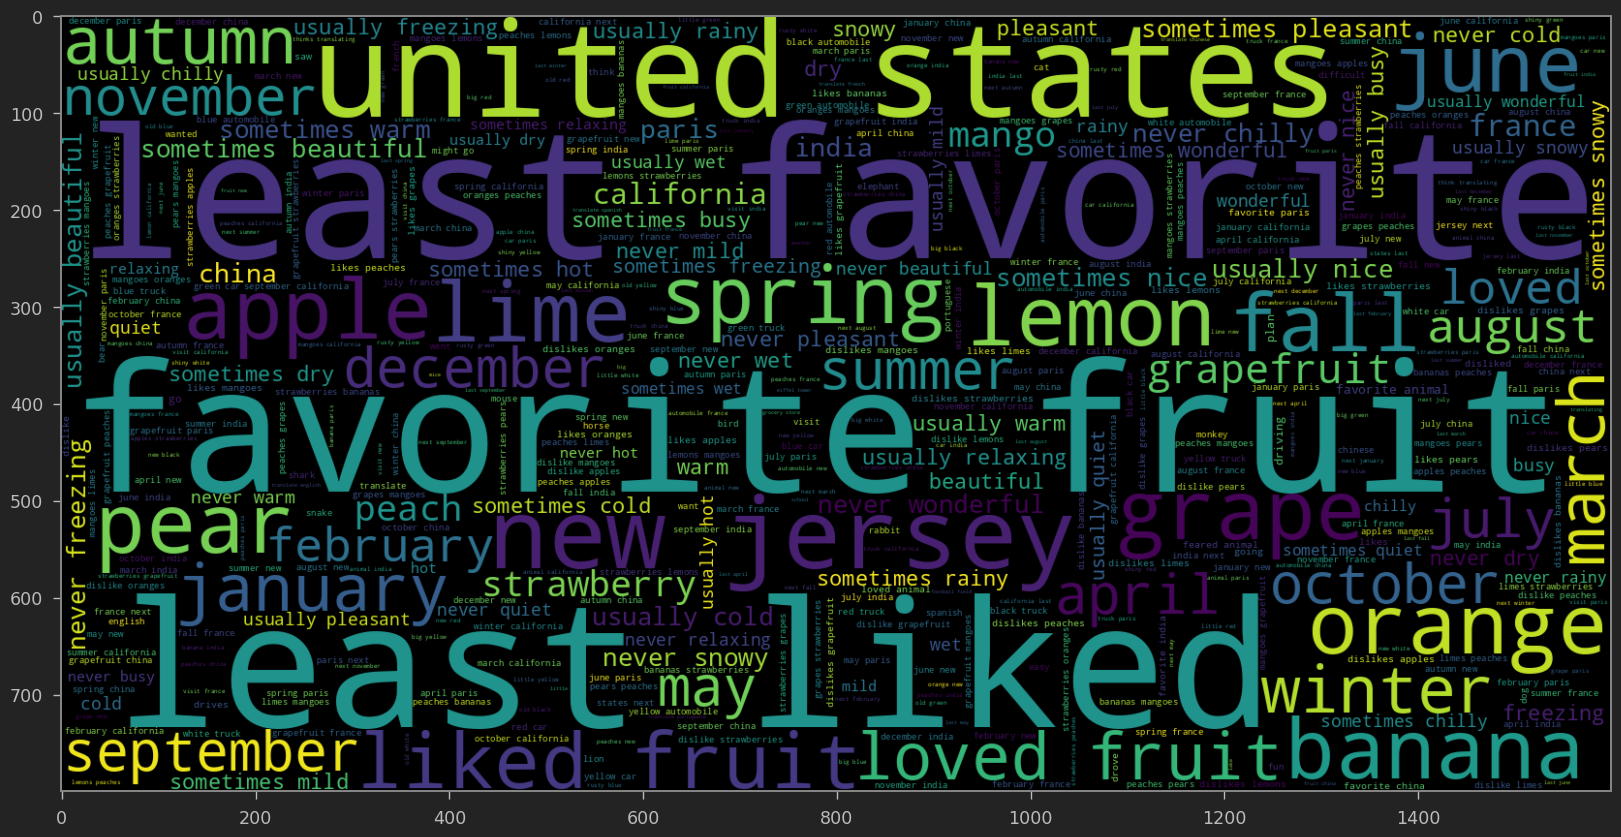

In [70]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(df.english))
plt.imshow(wc, interpolation = 'bilinear')

In [72]:
# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_english = -1
for doc in df.english:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_english < len(tokens)):
        maxlen_english = len(tokens)
print("The maximum number of words in any document = ", maxlen_english)

The maximum number of words in any document =  15


In [73]:
# obtain the count of french words
words = []
for i in df['french']:
  for word in i.split():
    words.append(word)

In [74]:
french_words_counts = Counter(words)

In [75]:
# sort the dictionary by values
french_words_counts = sorted(french_words_counts.items(), key = operator.itemgetter(1), reverse = True)

In [76]:
# append the values to a list for visuaization purpose
french_words = []
french_counts = []
for i in range(len(french_words_counts)):
  french_words.append(french_words_counts[i][0])
  french_counts.append(french_words_counts[i][1])

In [77]:
fig = px.bar(x = french_words, y = french_counts)
fig.show()

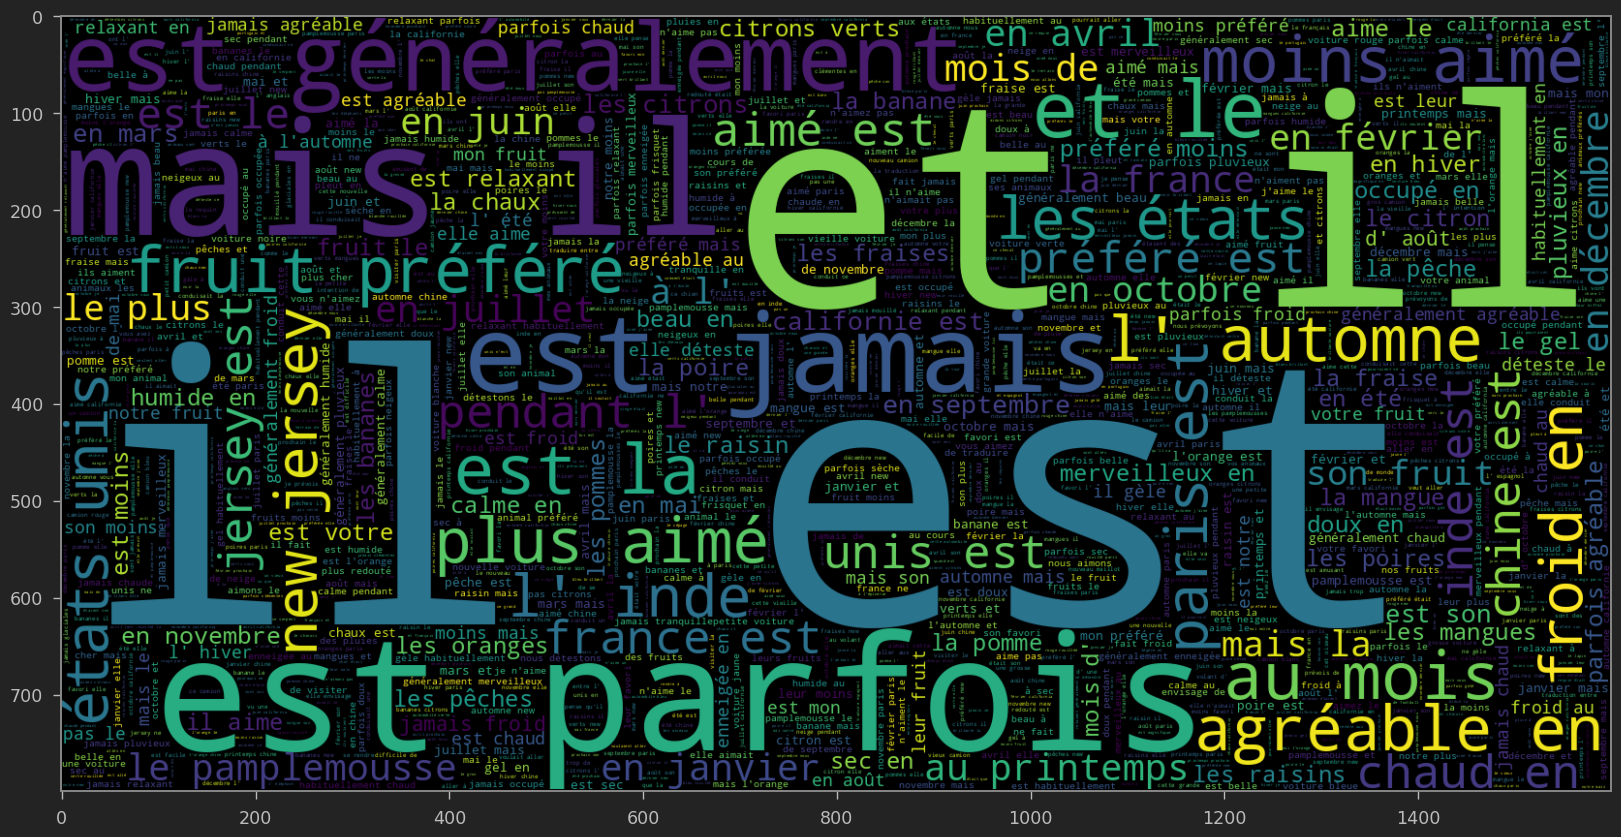

In [78]:
# plot the word cloud for French
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df.french))
plt.imshow(wc, interpolation = 'bilinear')

In [79]:
# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_french = -1
for doc in df.french:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_french < len(tokens)):
        maxlen_french = len(tokens)
print("The maximum number of words in any document = ", maxlen_french)

The maximum number of words in any document =  23


# PERFORMING TOKENIZATION AND PADDING

In [80]:
def tokenize_and_pad(x, maxlen):
  #  a tokenier to tokenize the words and create sequences of tokenized words
  tokenizer = Tokenizer(char_level = False)
  tokenizer.fit_on_texts(x)
  sequences = tokenizer.texts_to_sequences(x)
  padded = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
  return tokenizer, sequences, padded

In [81]:
# tokenize and padding to the data
x_tokenizer, x_sequences, x_padded = tokenize_and_pad(df.english, maxlen_english)
y_tokenizer, y_sequences, y_padded = tokenize_and_pad(df.french,  maxlen_french)

In [82]:
# Total vocab size, since we added padding we add 1 to the total word count
english_vocab_size = total_english_words + 1
print("Complete English Vocab Size:", english_vocab_size)

Complete English Vocab Size: 200


In [83]:
# Total vocab size, since we added padding we add 1 to the total word count
french_vocab_size = total_french_words + 1
print("Complete French Vocab Size:", french_vocab_size)

Complete French Vocab Size: 351


In [84]:
print("The tokenized version for document\n", df.english[-1:].item(),"\n is : ", x_padded[-1:])

The tokenized version for document
 the orange is her favorite fruit  but the banana is your favorite  
 is :  [[ 5 84  1 32 11 13  6  5 87  1 29 11  0  0  0]]


In [85]:
print("The tokenized version for document\n", df.french[-1:].item(),"\n is : ", y_padded[-1:])

The tokenized version for document
 l'orange est son fruit préféré  mais la banane est votre favori  
 is :  [[84  1 20 16 17  5  7 87  1 40 93  0  0  0  0  0  0  0  0  0  0  0  0]]


In [86]:
# function to obtain the text from padded variables
def pad_to_text(padded, tokenizer):

    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = ''

    return ' '.join([id_to_word[j] for j in padded])

In [87]:
pad_to_text(y_padded[0], y_tokenizer)

"new jersey est parfois calme pendant l' automne et il est neigeux en avril         "

In [88]:
# Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size = 0.1)

# BUILD AND TRAIN THE MODEL
english text > embedding > LSTM (encoder) > repeatvector> LSTM (decoder) >timedistribution(dense)> french text

In [90]:
# Sequential Model
model = Sequential()
# embedding layer
model.add(Embedding(english_vocab_size, 256, input_length = maxlen_english, mask_zero = True))
# encoder
model.add(LSTM(256))
# decoder
# repeatvector repeats the input for the desired number of times to change
# 2D-array to 3D array
model.add(RepeatVector(maxlen_french))
model.add(LSTM(256, return_sequences= True ))
model.add(TimeDistributed(Dense(french_vocab_size, activation ='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 15, 256)           51200     
                                                                 
 lstm_4 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 23, 256)           0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 23, 256)           525312    
                                                                 
 time_distributed_2 (TimeDi  (None, 23, 351)           90207     
 stributed)                                                      
                                                                 
Total params: 1192031 (4.55 MB)
Trainable params: 1192

In [91]:
# change the shape of target from 2D to 3D
y_train = np.expand_dims(y_train, axis = 2)
y_train.shape

(124074, 23, 1)

In [92]:
# train the model
model.fit(x_train, y_train, batch_size=1024, validation_split= 0.1, epochs=30)

Epoch 1/30
110/110 [==============================] - 19s 112ms/step - loss: 2.7532 - accuracy: 0.4895 - val_loss: 2.1773 - val_accuracy: 0.5425
Epoch 2/30
110/110 [==============================] - 6s 57ms/step - loss: 1.9293 - accuracy: 0.5648 - val_loss: 1.6628 - val_accuracy: 0.5927
Epoch 3/30
110/110 [==============================] - 6s 59ms/step - loss: 1.5252 - accuracy: 0.6131 - val_loss: 1.4283 - val_accuracy: 0.6281
Epoch 4/30
110/110 [==============================] - 6s 56ms/step - loss: 1.3307 - accuracy: 0.6477 - val_loss: 1.2301 - val_accuracy: 0.6670
Epoch 5/30
110/110 [==============================] - 7s 60ms/step - loss: 1.1437 - accuracy: 0.6827 - val_loss: 1.0595 - val_accuracy: 0.7049
Epoch 6/30
110/110 [==============================] - 6s 59ms/step - loss: 0.9911 - accuracy: 0.7211 - val_loss: 0.9296 - val_accuracy: 0.7367
Epoch 7/30
110/110 [==============================] - 6s 59ms/step - loss: 0.8733 - accuracy: 0.7505 - val_loss: 0.9536 - val_accuracy: 0.72

In [47]:
model.save("weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# TRAINED MODEL PERFORMANCE


In [93]:
# function to make prediction
def prediction(x, x_tokenizer = x_tokenizer, y_tokenizer = y_tokenizer):
    predictions = model.predict(x)[0]
    id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
    id_to_word[0] = ''
    return ' '.join([id_to_word[j] for j in np.argmax(predictions,1)])

In [94]:
for i in range(5):

  print('Original English word - {}\n'.format(pad_to_text(x_test[i], x_tokenizer)))
  print('Original French word - {}\n'.format(pad_to_text(y_test[i], y_tokenizer)))
  print('Predicted French word - {}\n\n\n\n'.format(prediction(x_test[i:i+1])))

Original English word - new jersey is mild during spring but it is snowy in summer   

Original French word - new jersey est doux au printemps mais il est neigeux en été           

1/1 [==============================] - 2s 2s/step
Predicted French word - new jersey est doux au printemps mais il est neigeux en été           




Original English word - he dislikes grapes limes and lemons         

Original French word - il aime pas les raisins citrons verts et les citrons             

1/1 [==============================] - 0s 18ms/step
Predicted French word - il aime pas les raisins citrons verts et les citrons             




Original English word - the lime is his least liked fruit but the pear is our least liked 

Original French word - la chaux est son fruit moins aimé mais la poire est notre moins aimé         

1/1 [==============================] - 0s 18ms/step
Predicted French word - la chaux est son fruit moins aimé mais la poire est notre moins aimé         




Original En